In [1]:
%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import PowerNorm

from skimage.util import compare_images

import SimpleITK as sitk # To save the image

import viewscad

import gvxrPython3 as gvxr # Simulate X-ray images

import json2gvxr

SimpleGVXR 1.0.1 (2021-04-01T17:18:35) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2021-04-01T17:18:28) [Compiler: GNU g++] on Linux


We first create a CAD model using [OpenSCAD](https://openscad.org/) and extract the STL files

In [2]:
gate_image = sitk.GetArrayFromImage(sitk.ReadImage("../Gate/output/energy.mhd"))[0];

In [3]:
gate_image = (gate_image - np.mean(gate_image)) / np.std(gate_image);

In [4]:
json2gvxr.initGVXR("simulation.json", "OPENGL");

Create an OpenGL context: 800x450


In [5]:
json2gvxr.initSourceGeometry();

Set up the beam
	Source position: [0.0, 0.0, 1000.0, 'mm']
	Source shape: PointSource


In [6]:
spectrum, unit = json2gvxr.initSpectrum(verbose=1);

/gate/source/mybeam/gps/emin 11.0 keV
/gate/source/mybeam/gps/emax 90.0 keV
/gate/source/mybeam/gps/histpoint 0.011 3
/gate/source/mybeam/gps/histpoint 0.0115 12
/gate/source/mybeam/gps/histpoint 0.012 40
/gate/source/mybeam/gps/histpoint 0.0125 148
/gate/source/mybeam/gps/histpoint 0.013 519
/gate/source/mybeam/gps/histpoint 0.0135 1565
/gate/source/mybeam/gps/histpoint 0.014 4090
/gate/source/mybeam/gps/histpoint 0.0145 9474
/gate/source/mybeam/gps/histpoint 0.015 19789
/gate/source/mybeam/gps/histpoint 0.0155 37826
/gate/source/mybeam/gps/histpoint 0.016 67047
/gate/source/mybeam/gps/histpoint 0.0165 111380
/gate/source/mybeam/gps/histpoint 0.017 174907
/gate/source/mybeam/gps/histpoint 0.0175 261254
/gate/source/mybeam/gps/histpoint 0.018 373324
/gate/source/mybeam/gps/histpoint 0.0185 513706
/gate/source/mybeam/gps/histpoint 0.019 684248
/gate/source/mybeam/gps/histpoint 0.0195 885574
/gate/source/mybeam/gps/histpoint 0.02 1116396
/gate/source/mybeam/gps/histpoint 0.0205 1374186
/

In [7]:
print("kvp:", json2gvxr.params["Source"]["Beam"]["kvp"]);
print("filter material:", json2gvxr.params["Source"]["Beam"]["filter"][0]);
print("filter thickness (in mm):", json2gvxr.params["Source"]["Beam"]["filter"][1]); 

kvp: 90
filter material: Al
filter thickness (in mm): 3.2


Text(0.5, 1.0, 'X-ray spectrum')

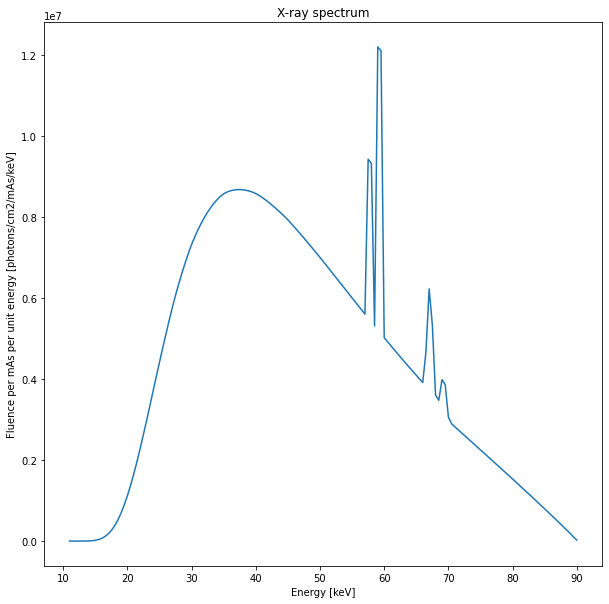

In [8]:
energy_set = sorted(spectrum.keys())
count_set = [];

for energy in energy_set:
    count_set.append(spectrum[energy])
    
plt.figure(figsize= (10,10))
plt.plot(energy_set, count_set) # Plot the spectrum
plt.xlabel('Energy [keV]')
plt.ylabel('Fluence per mAs per unit energy [photons/cm2/mAs/keV]')
plt.title('X-ray spectrum')

In [9]:
json2gvxr.initDetector();

Set up the detector
	Detector position: [0.0, 0.0, -125.0, 'mm']
	Detector up vector: [0, 1, 0]
	Detector number of pixels: [512, 512]
	Pixel spacing: [0.29296875, 0.29296875, 'mm']


In [10]:
openscad_make_spheres_str = """

module make_column_of(sphere_radius, height, count)
{
    step = height / (count - 1);
    for (a = [0 : count - 1]) {
        offset = -height / 2 + step * a ;
        translate([0, offset, 0])
            sphere(sphere_radius[a], $fa=5, $fs=0.1);
    }
}

module make_row_of(radius, count, id)
{
    step = radius / (count - 1);
    for (a = [0 : count - 1]) {
        if (id == -1 || id == a) {
            offset = -radius / 2 + step * a ;
            translate([offset, 0, 0])
                children();
        }
    }
}

module make_spheres(sphere_radius, ring_radius, ring_count, column_height, column_count, id = -1)
{
    make_row_of(radius = ring_radius, count = ring_count, id = id)
        make_column_of(sphere_radius, height = column_height, count = column_count);
}
"""

The matrix

In [11]:
openscad_matrix_str = """

color("red")
    difference() {
        scale([70, 70, 15])
            cube(1, center = true);
        make_spheres([2, 3.5, 5], 50, 5, 40, 3, -1);
}

"""

In [12]:
r = viewscad.Renderer()
r.render(openscad_matrix_str + openscad_make_spheres_str, outfile='matrix.stl')

In [13]:
openscad_cube_str = """

color("red")
    scale([70, 70, 15])
        cube(1, center = true);

"""

In [14]:
r = viewscad.Renderer()
r.render(openscad_cube_str, outfile='cube.stl')

The spheres

In [15]:
openscad_col_str_set = [];

for i in range(5):
    openscad_col_str_set.append("""
    color("blue")
        make_spheres([2, 3.5, 5], 50, 5, 40, 3, """ + str(i) + ");");
        
    r = viewscad.Renderer()
    r.render(openscad_col_str_set[-1] + openscad_make_spheres_str, outfile='col_' + str(i) + '.stl')

In [16]:
json2gvxr.initSamples(verbose=2);

Load the 3D data

Bone_Cortical_ICRU_44: d=1.92 g/cm3 ; n=9 ; state=solid
        +el: name=Hydrogen ; f=0.034
        +el: name=Carbon ; f=0.155
        +el: name=Nitrogen ; f=0.042
        +el: name=Oxygen ; f=0.435
        +el: name=Sodium ; f=0.001
        +el: name=Magnesium ; f=0.002
        +el: name=Phosphor ; f=0.103
        +el: name=Sulfur ; f=0.003
        +el: name=Calcium ; f=0.225

Blood_Whole_ICRU_44: d=1.06 g/cm3 ; n=10 ; state=solid
        +el: name=Hydrogen ; f=0.102
        +el: name=Carbon ; f=0.11
        +el: name=Nitrogen ; f=0.033
        +el: name=Oxygen ; f=0.745
        +el: name=Sodium ; f=0.001
        +el: name=Phosphor ; f=0.001
        +el: name=Sulfur ; f=0.002
        +el: name=Chlorine ; f=0.003
        +el: name=Potassium ; f=0.002
        +el: name=Iron ; f=0.001

Brain_Grey_White_Matter_ICRU_44: d=1.04 g/cm3 ; n=9 ; state=solid
        +el: name=Hydrogen ; f=0.107
        +el: name=Carbon ; f=0.145
        +el: name=Nitrogen ; f=0.022
        +el

Update the 3D visualisation and take a screenshot

In [17]:
gvxr.displayScene();

gvxr.useLighing();
gvxr.useWireframe();
gvxr.setZoom(719.6787109375);
gvxr.setSceneRotationMatrix([0.7624880075454712, 0.09040657430887222, -0.6406543850898743, 0.0,
                             0.05501500517129898, 0.9775413870811462, 0.20342488586902618, 0.0,
                             0.6446591019630432, -0.190354123711586, 0.7403913140296936, 0.0,
                             0.0, 0.0, 0.0, 1.0]);

gvxr.displayScene();

In [18]:
screenshot = gvxr.takeScreenshot();

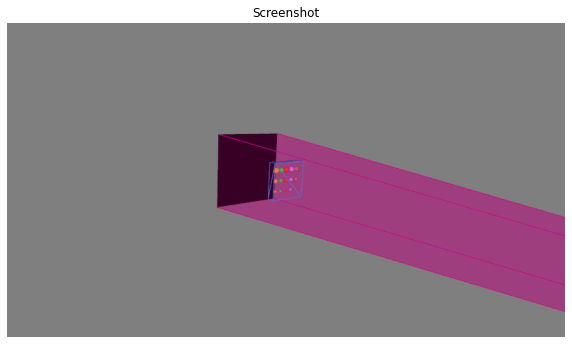

In [19]:
plt.figure(figsize= (10,10))
plt.title("Screenshot");
plt.imshow(screenshot);
plt.axis('off');

Compute an X-ray image and add it to the list of projections

In [20]:
x_ray_image = gvxr.computeXRayImage();

In [21]:
volume = sitk.GetImageFromArray(x_ray_image);
sitk.WriteImage(volume, 'projection.mha');

In [22]:
x_ray_image = (x_ray_image - np.mean(x_ray_image)) / np.std(x_ray_image);

Update the 3D visualisation and take a screenshot

In [23]:
gvxr.displayScene();

In [24]:
screenshot = gvxr.takeScreenshot();

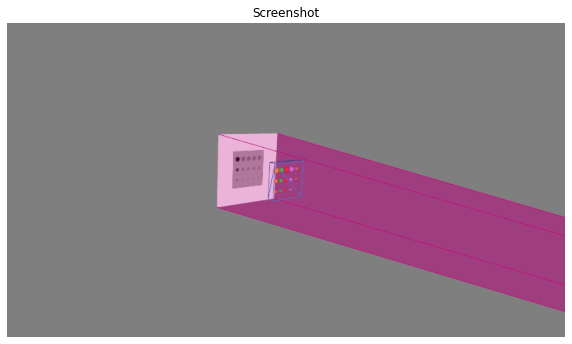

In [25]:
plt.figure(figsize= (10,10))
plt.title("Screenshot");
plt.imshow(screenshot);
plt.axis('off');

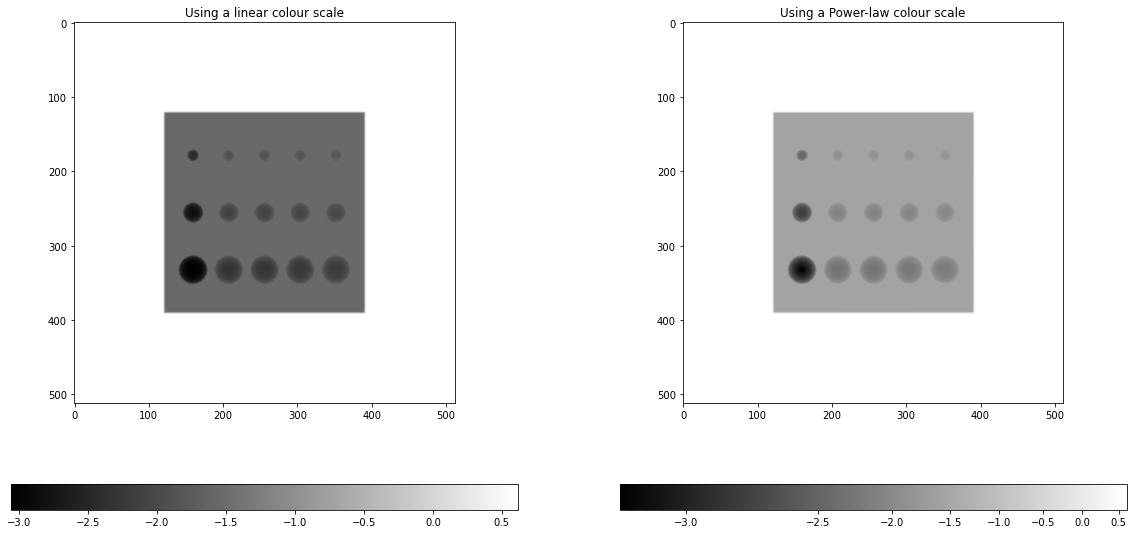

In [26]:
# Plot the projection
plt.figure(figsize= (20,10))
plt.subplot(121)
plt.imshow(x_ray_image, cmap="gray");
plt.colorbar(orientation='horizontal');
plt.title("Using a linear colour scale");

plt.subplot(122)
plt.imshow(x_ray_image, norm=PowerNorm(gamma=1./2.), cmap="gray");
plt.colorbar(orientation='horizontal');
plt.title("Using a Power-law colour scale");

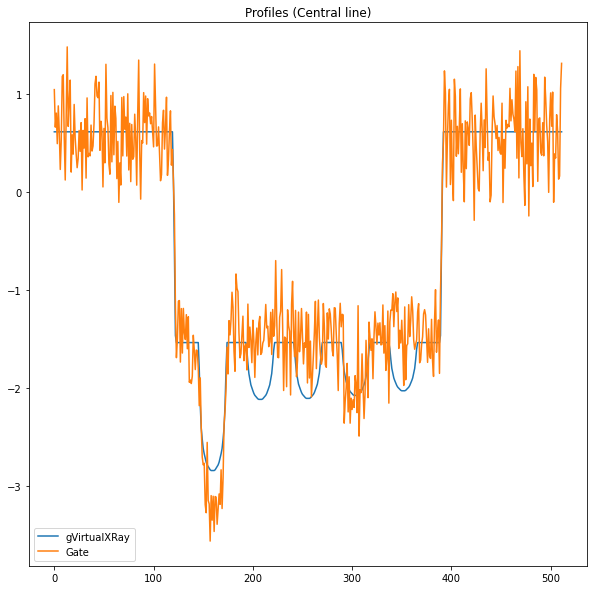

In [27]:
plt.figure(figsize= (10,10))
plt.title("Profiles (Central line)");
# plt.yscale("log")
plt.plot(x_ray_image[round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2)], label="gVirtualXRay")
plt.plot(gate_image[round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2)], label="Gate")
plt.legend()

In [28]:
gvxr.destroyAllWindows()

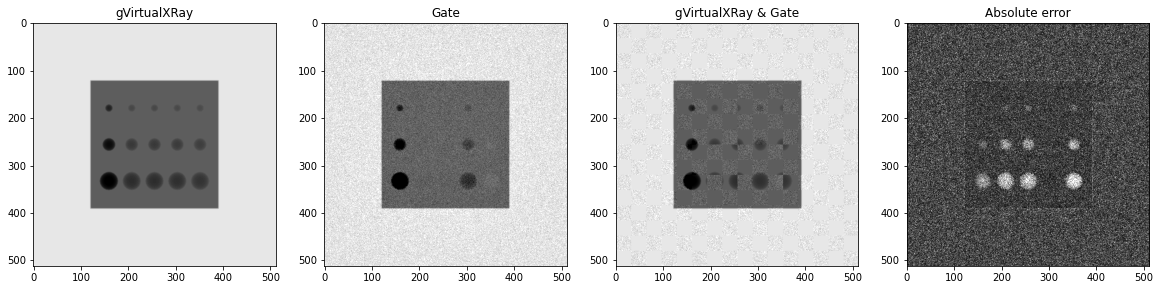

In [29]:
absolute_error = np.abs(gate_image - x_ray_image);
comp_equalized = compare_images(gate_image, x_ray_image, method='checkerboard', n_tiles=(16,16))

plt.figure(figsize= (20,10))

plt.subplot(141)
plt.imshow(x_ray_image, cmap="gray", vmin=-3, vmax=1);
plt.title("gVirtualXRay");

plt.subplot(142)
plt.imshow(gate_image, cmap="gray", vmin=-3, vmax=1);
plt.title("Gate");

plt.subplot(143)
plt.imshow(comp_equalized, cmap="gray", vmin=-3, vmax=1);
plt.title("gVirtualXRay & Gate");

plt.subplot(144)
plt.imshow(absolute_error, cmap="gray", vmin=0, vmax=1);
plt.title("Absolute error");

In [30]:
ZNCC = np.mean(gate_image * x_ray_image);
print(ZNCC)

0.9362243905699444
